## AML Package for Text Analytics - Text Classification
### Text Classification using multiple columns as features

In this notebook, you can learn how to train and deploy a text classification model with **Azure Machine Learning Package for Text Analytics** (AMLPTA), on multiple input columns. Numeric user-provided columns as well as numeric features extracted from text columns will be used as features for text classification. <br>

This notebook example uses the [news group data](http://qwone.com/~jason/20Newsgroups/) to demonstrate the application of the Azure ML Text Analytics Package for text classification with a scikit-learn pipeline.

Consult the [package reference documentation](https://aka.ms/aml-packages/text) for the detailed reference for each module and class.

Following are the steps for creating and deploying a text classifier model using the package:
<br> Step 1: Loading the training dataset
<br> Step 2: Model training
<br> Step 3: Apply the Classifier 
<br> Step 4: Performance evaluation
<br> Step 5: Save the pipeline
<br> Step 6: Load the pipeline
<br> Step 7: Test the pipeline
<br> Step 8: Operationalize - Deploy the pipeline

## Prerequisites 

1. If you don't have an Azure subscription, create a [free account](https://azure.microsoft.com/free/?WT.mc_id=A261C142F) before you begin.

1. The following accounts and application must be set up and installed:
   - Azure Machine Learning Experimentation account 
   - An Azure Machine Learning Model Management account
   - Azure Machine Learning Workbench installed

   If these three are not yet created or installed, follow the [Azure Machine Learning Quickstart and Workbench installation](../service/quickstart-installation.md) article. 

1. The Azure Machine Learning Package for Text Analytics must be installed. Learn how to [install this package here](https://aka.ms/aml-packages/text).

## Imports

In [1]:
# Use the Azure Machine Learning data collector to log various metrics
from azureml.logging import get_azureml_logger
import os
import pandas as pd
import numpy as np
import tatk
import matplotlib.pyplot as plt
import itertools
import warnings
from tatk.pipelines.text_classification.text_classifier import TextClassifier

# Log cell runs into run history
logger = get_azureml_logger()
logger.log('Cell','Set up run')

warnings.filterwarnings("ignore")

---
Metadata-Version: 2.0
Name: azureml-tatk
Version: 0.1.18121.30a1
Summary: Microsoft Azure Machine Learning Package for Text Analytics
Home-page: https://microsoft.sharepoint.com/teams/TextAnalyticsPackagePreview
Author: Microsoft Corporation
Author-email: amltap@microsoft.com
Installer: pip
License: UNKNOWN
Location: c:\users\tatk\appdata\local\amlworkbench\python\lib\site-packages
Requires: pytest, nltk, qgrid, pyspark, h5py, scikit-learn, lxml, requests, matplotlib, ruamel.yaml, azure-storage, docker, dill, azure-ml-api-sdk, bqplot, sklearn-crfsuite, ipywidgets, pandas, gensim, pdfminer.six, numpy, jsonpickle, validators, unidecode, scipy, nose, ipython, keras
Classifiers:


You are using pip version 8.1.2, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Step 1: Loading the dataset

### Download and Explore the sample data
The following example uses the [20 newsgroups dataset](http://qwone.com/~jason/20Newsgroups/)  that is available through the scikit-learn library to demonstrate how to create a text classifier with Azure Machine Learning Package for Text Analytics. 

The 20 newsgroups dataset has around 18,000 newsgroups posts on 20 different topics divided into two subsets: one for training and the other one for performance evaluation. The split into train and test is based upon each message post date whether before or after a specific date. 

We copied the text column twice and added a numeric column with random values into a Pandas dataframe. This dataset demonstrates the capability of the package to support training data with multiple text and numeric columns to train a classifcation model. 
<br> Update the DataFrame to fit your data format.  

In [2]:
# Downloads the benchmark newsgroup training and test data sets

from tatk.utils import data_dir, dictionaries_dir, models_dir, resources_dir, download_blob_from_storage
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.graphics', 'rec.autos','sci.med', 'misc.forsale']
twenty_train = fetch_20newsgroups(data_home=data_dir, subset='train', categories=categories, shuffle=True, random_state=42)
X_train, y_train = twenty_train.data, twenty_train.target
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)
X_test, y_test = twenty_test.data, twenty_test.target   


# Add artificial columns to illustrate the package capabilities
random_col = np.random.random_sample(size=(len(X_train),))
bool_col = [False] *len(X_train)
df_train = pd.DataFrame({"text1":X_train, "text2":X_train, "bool_col":bool_col, "random_col":random_col, "label":y_train})
print("df_train.shape = {}".format(df_train.shape))


random_col = np.random.random_sample(size=(len(X_test),))
bool_col = [False] *len(X_test)
df_test = pd.DataFrame({"text1":X_test, "text2":X_test, "bool_col":bool_col, "random_col":random_col, "label":y_test})
print("df_test.shape  = {}".format(df_test.shape))


# input columns for training and testing
text_cols = ['text1']      # ['text1', 'text2']
numeric_cols = None        # ['random_col']
cat_cols = None            # ['bool_col']
label_cols = ['label']

df_train.to_csv(data_dir+"\\20news_train.csv")
df_train.head()

df_train.shape = (2357, 5)
df_test.shape  = (1571, 5)


,bool_col,label,random_col,text1,text2
0,False,1,0.752470,From: warsaw@athena.mit.edu (Daniel Maung)\nSu...,From: warsaw@athena.mit.edu (Daniel Maung)\nSu...
1,False,3,0.894639,From: kxgst1+@pitt.edu (Kenneth Gilbert)\nSubj...,From: kxgst1+@pitt.edu (Kenneth Gilbert)\nSubj...
2,False,3,0.956046,From: ron.roth@rose.com (ron roth)\nSubject: S...,From: ron.roth@rose.com (ron roth)\nSubject: S...
3,False,1,0.477918,From: mkao@mace.cc.purdue.edu (Michelle Kao)\n...,From: mkao@mace.cc.purdue.edu (Michelle Kao)\n...
4,False,2,0.810862,From: callison@uokmax.ecn.uoknor.edu (James P....,From: callison@uokmax.ecn.uoknor.edu (James P....


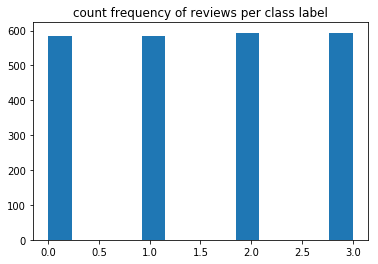

In [3]:
%matplotlib inline
plt.hist(df_train['label'], bins = "auto")
plt.title("count frequency of reviews per class label")
plt.show()

## Step 2: Model training
This step involves training a Scikit-learn text classification model using One-versus-Rest Logistic Regression learning algorithm.
Full list of learners can be found here [Scikit Learners](http://scikit-learn.org/stable/supervised_learning)

In [4]:
from sklearn.linear_model import LogisticRegression

text_classifier = TextClassifier(estimator = LogisticRegression(),
                                text_cols = text_cols,
                                label_cols = label_cols,
                                numeric_cols = numeric_cols,
                                cat_cols = cat_cols, 
                                extract_word_ngrams = True, 
                                extract_char_ngrams = True)

TextClassifier::create_pipeline ==> start
:: number of jobs for the pipeline : 6
0	text1_nltk_preprocessor
1	text1_word_ngrams
2	text1_char_ngrams
3	assembler
4	learner
TextClassifier::create_pipeline ==> end


Train the model using the default parameters of the package: By default, the text classifier will extract word unigrams and bigrams and character 4-grams.

In [5]:
text_classifier = text_classifier.fit(df_train)  

TextClassifier::fit ==> start
schema: col=bool_col:BL:0 col=label:I8:1 col=random_col:R4:2 col=text1:TX:3 col=text2:TX:4 header+
NltkPreprocessor::tatk_fit_transform ==> start
NltkPreprocessor::tatk_fit_transform ==> end 	 Time taken: 0.01 mins
NGramsVectorizer::tatk_fit_transform ==> startNGramsVectorizer::tatk_fit_transform ==> start

			vocabulary size=44909
NGramsVectorizer::tatk_fit_transform ==> end 	 Time taken: 0.07 mins
			vocabulary size=24471
NGramsVectorizer::tatk_fit_transform ==> end 	 Time taken: 0.08 mins
VectorAssembler::transform ==> start, num of input records=2357
(2357, 44909)
(2357, 24471)
all_features::
(2357, 69380)
Time taken: 0.01 mins
VectorAssembler::transform ==> end
LogisticRegression::tatk_fit ==> start
LogisticRegression::tatk_fit ==> end 	 Time taken: 0.02 mins
Time taken: 0.12 mins
TextClassifier::fit ==> end


### How to read and modify the parameters of the different pipeline steps

Get step params by step name in the pipeline

In [6]:
# read the parameters of the character n-gram extraction module
text_classifier.get_step_params_by_name("text1_char_ngrams")

{'analyzer': 'char_wb',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float32,
 'encoding': 'utf-8',
 'hashing': False,
 'input': 'content',
 'input_col': 'NltkPreprocessor01b6c3d7811e426293e31ba75cc4b881',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 3,
 'n_hashing_features': None,
 'ngram_range': (4, 4),
 'norm': 'l2',
 'output_col': 'NGramsVectorizer314df3a38b9343c78c6c6ae175001d7d',
 'preprocessor': None,
 'save_overwrite': True,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

You can change the default parameters as follows: here we show how to change the range of extracted character n-grams from (4,4) to (3,4) to extract both character tri-grams and 4-grams.  

In [7]:
text_classifier.set_step_params_by_name("text1_char_ngrams", ngram_range =(3,4), use_idf = False) 
text_classifier.get_step_params_by_name("text1_char_ngrams")

{'analyzer': 'char_wb',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float32,
 'encoding': 'utf-8',
 'hashing': False,
 'input': 'content',
 'input_col': 'NltkPreprocessor01b6c3d7811e426293e31ba75cc4b881',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 3,
 'n_hashing_features': None,
 'ngram_range': (3, 4),
 'norm': 'l2',
 'output_col': 'NGramsVectorizer314df3a38b9343c78c6c6ae175001d7d',
 'preprocessor': None,
 'save_overwrite': True,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': False,
 'vocabulary': None}

#### Export the classifier parameters into a file

In [8]:
params_file_path = os.path.join(data_dir, "params.tsv")
text_classifier.export_params(params_file_path)
params_file_path

'C:\\Users\\tatk\\tatk\\resources\\data\\params.tsv'

## Step 3: Apply the classifier
Apply the trained text classifier on the test dataset

In [9]:
df_test = text_classifier.predict(df_test)
df_test.head()

TextClassifier ::predict ==> start
NltkPreprocessor::tatk_transform ==> start
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.01 mins
NGramsVectorizer::tatk_transform ==> startNGramsVectorizer::tatk_transform ==> start

NGramsVectorizer::tatk_transform ==> end 	 Time taken: 0.02 mins
NGramsVectorizer::tatk_transform ==> end 	 Time taken: 0.06 mins
VectorAssembler::transform ==> start, num of input records=1571
(1571, 44909)
(1571, 24471)
all_features::
(1571, 69380)
Time taken: 0.0 mins
VectorAssembler::transform ==> end
LogisticRegression::tatk_predict_proba ==> start
LogisticRegression::tatk_predict_proba ==> end 	 Time taken: 0.0 mins
LogisticRegression::tatk_predict ==> start
LogisticRegression::tatk_predict ==> end 	 Time taken: 0.0 mins
Time taken: 0.08 mins
TextClassifier ::predict ==> end
Order of Labels in predicted probabilities saved to attribute label_order of the class object


,bool_col,label,random_col,text1,text2,probabilities,prediction
0,False,2,0.842559,From: bpita@ctp.com (Bob Pitas)\nSubject: Re: ...,From: bpita@ctp.com (Bob Pitas)\nSubject: Re: ...,"[0.112418208514, 0.0459501014764, 0.5786911101...",2
1,False,0,0.581815,From: abh@genesis.nred.ma.us (Andrew Hudson)\n...,From: abh@genesis.nred.ma.us (Andrew Hudson)\n...,"[0.630064353888, 0.151804497589, 0.12041231633...",0
2,False,0,0.220681,From: dconway@hpldsla.sid.hp.com (Dan Conway)\...,From: dconway@hpldsla.sid.hp.com (Dan Conway)\...,"[0.46381642404, 0.0553313750719, 0.33860331270...",0
3,False,0,0.491511,From: kyle@wam.umd.edu (Kyle Xavier Hourihan)\...,From: kyle@wam.umd.edu (Kyle Xavier Hourihan)\...,"[0.100927034437, 0.0293698589904, 0.4919934064...",2
4,False,2,0.426309,From: al@qiclab.scn.rain.com (Alan Peterman)\n...,From: al@qiclab.scn.rain.com (Alan Peterman)\n...,"[0.050065255943, 0.024002715854, 0.71967956608...",2


## Step 4: Performance evaluation
The Evaluation module evaluates the accuracy of the trained text classifier on the test dataset.

TextClassifier ::evaluate ==> start
Time taken: 0.0 mins
TextClassifier ::evaluate ==> end
Confusion matrix, without normalization
[[348   4  34   3]
 [  8 359  22   1]
 [  4   9 382   1]
 [ 18  19  59 300]]


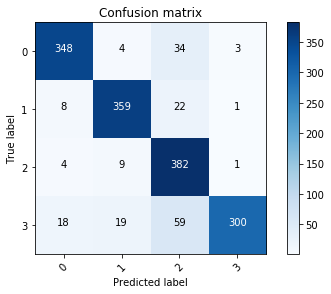

In [10]:
evaluator = text_classifier.evaluate(df_test)          
evaluator.plot_confusion_matrix()

In [11]:
evaluator.get_metrics("macro_f1")

0.88455724141593861

In [12]:
evaluator.get_metrics('micro_avg_accuracy')

0.88415022278803312

In [13]:
evaluator.get_metrics('macro_avg_accuracy')

0.88433414628787377

## Step 5: Save the pipeline
#### Save the classification pipeline into a zip file and the word-ngrams and character n-grams into text files


In [14]:
working_dir = os.path.join(data_dir, 'outputs')  
if not os.path.exists(working_dir):
    os.makedirs(working_dir)

# you can save the trained model as a folder or a zip file
model_file = os.path.join(working_dir, 'sk_model04.zip')    
text_classifier.save(model_file)
# %azureml upload outputs/models/sk_model.zip

# for debugging, you can save the word n-grams vocabulary to a text file
word_vocab_file_path = os.path.join(working_dir, 'word_ngrams_vocabulary.tsv')
text_classifier.get_step_by_name("text1_word_ngrams").save_vocabulary(word_vocab_file_path) 
# %azureml upload outputs/dictionaries/word_ngrams_vocabulary.pkl

# for debugging, you can save the character n-grams vocabulary to a text file
char_vocab_file_path = os.path.join(working_dir, 'char_ngrams_vocabulary.tsv')
text_classifier.get_step_by_name("text1_char_ngrams").save_vocabulary(char_vocab_file_path) 
# %azureml upload outputs/dictionaries/char_ngrams_vocabulary.pkl

model_file

BaseTextModel::save ==> start
TatkPipeline::save ==> start
Time taken: 0.06 mins
TatkPipeline::save ==> end
Time taken: 0.08 mins
BaseTextModel::save ==> end
save_vocabulary ==> start
saving 44909 n-grams ...
Time taken: 0.0 mins
save_vocabulary ==> end
save_vocabulary ==> start
saving 24471 n-grams ...
Time taken: 0.0 mins
save_vocabulary ==> end


'C:\\Users\\tatk\\tatk\\resources\\data\\outputs\\sk_model04.zip'

## Step 6: Load the pipeline
#### Load the classification pipeline and the word-ngrams and character n-grams

In [15]:
# in order to deploy the trained model, you have to load the zip file of the classifier pipeline
loaded_text_classifier = TextClassifier.load(model_file)

from tatk.feature_extraction import NGramsVectorizer
word_ngram_vocab = NGramsVectorizer.load_vocabulary(word_vocab_file_path)
char_ngram_vocab = NGramsVectorizer.load_vocabulary(char_vocab_file_path)

BaseTextModel::load ==> start
TatkPipeline::load ==> start
Time taken: 0.03 mins
TatkPipeline::load ==> end
Time taken: 0.03 mins
BaseTextModel::load ==> end
loading 44909 n-grams ...
loading 24471 n-grams ...


## Step 7: Test the pipeline
### Apply the loaded text classification pipeline

TextClassifier ::predict ==> start
NltkPreprocessor::tatk_transform ==> start
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.01 mins
NGramsVectorizer::tatk_transform ==> startNGramsVectorizer::tatk_transform ==> start

NGramsVectorizer::tatk_transform ==> end 	 Time taken: 0.02 mins
NGramsVectorizer::tatk_transform ==> end 	 Time taken: 0.06 mins
VectorAssembler::transform ==> start, num of input records=1571
(1571, 44909)
(1571, 24471)
all_features::
(1571, 69380)
Time taken: 0.0 mins
VectorAssembler::transform ==> end
LogisticRegression::tatk_predict_proba ==> start
LogisticRegression::tatk_predict_proba ==> end 	 Time taken: 0.0 mins
LogisticRegression::tatk_predict ==> start
LogisticRegression::tatk_predict ==> end 	 Time taken: 0.0 mins
Time taken: 0.08 mins
TextClassifier ::predict ==> end
Order of Labels in predicted probabilities saved to attribute label_order of the class object
TextClassifier ::evaluate ==> start
Time taken: 0.0 mins
TextClassifier ::evaluate ==> en

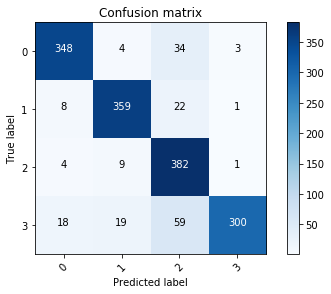

0.88455724141593861

In [16]:
df_test = loaded_text_classifier.predict(df_test)
evaluator = loaded_text_classifier.evaluate(df_test)          
evaluator.plot_confusion_matrix()
evaluator.get_metrics("macro_f1")

## Step 8: Operationalize - Deploy to Azure Web Service and Consume


In this section, you deploy the text classification pipeline as an Azure Machine Learning web service using [Azure Machine Learning CLI](https://docs.microsoft.com/azure/machine-learning/desktop-workbench/cli-for-azure-machine-learning). Then, you consume the web service for training and scoring.

**Log in to your Azure subscription with Azure CLI**

Using an [Azure](https://azure.microsoft.com/) account with a valid subscription, log in using the following CLI command:
<br>`az login`

+ To switch to another Azure subscription, use the command:
<br>`az account set --subscription [your subscription name]`

+ To see the current model management account, use the command:
  <br>`az ml account modelmanagement show`

**Create and set your deployment environment**

You only need to set your deployment environment once. If you don't have one yet, set up your deployment environment now using [these instructions](https://docs.microsoft.com/azure/machine-learning/desktop-workbench/deployment-setup-configuration#environment-setup). 

1- Make sure your Azure Machine Learning environment, model management account, and resource group are located in the same region.

2- Download the deployment configuration file from Blob storage and save it locally:

In [17]:
# Download the deployment config file from Blob storage `url` and save it locally under `file_name`:
deployment_config_file_url = 'https://aztatksa.blob.core.windows.net/dailyrelease/tatk_deploy_config.yaml'
deployment_config_file_path=os.path.join(resources_dir, 'tatk_deploy_config.yaml')
if not os.path.exists(deployment_config_file_path):
    import urllib.request
    print('downloading {}'.format(deployment_config_file_path))
    urllib.request.urlretrieve(deployment_config_file_url, deployment_config_file_path)
deployment_config_file_path

'C:\\Users\\tatk\\tatk\\resources\\tatk_deploy_config.yaml'

3- Update the deployment configuration file you downloaded to reflect your resources:
Please write the path to a local working directory. 

In [18]:
working_directory =r'<please provide a working directory on your machine here>'
web_service_name = 'multitext-classifier'

web_service = text_classifier.deploy(web_service_name= web_service_name, 
                                     config_file_path=deployment_config_file_path,
                                     working_directory= working_directory)  

The deployment has started.
Checking CLI azure machine learning installation setting
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az account set --subscription Azure Internal - Carl
running az group list
Checking CLI azure machine learning model management setting
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml account modelmanagement list
Will use model management account: "tutorial4vienna-model-mgr".
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml account modelmanagement set -n tutorial4vienna-model-mgr -g ner-rg
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml env list
Checking CLI azure machine learning environment setting
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az provider list
Checking provider registration...
All required providers are registered.
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml env show -n env4textclassifier -g env4textclassifierrg
ru

Additional usage information: 'az ml service usage realtime -i multitext-classifier.env4textclassifier-7d271640.eastus2'
Deployment finished successfully!
changing the working directory back to : C:\Users\tatk\Documents\AzureML\TATK-Tutorial
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service list realtime
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service list realtime
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service show realtime --name multitext-classifier
[
  {
    "Id": "multitext-classifier.env4textclassifier-7d271640.eastus2",
    "Image_URL": "mlcrpacr91e76789f01e.azurecr.io/multitext-classifier:1",
    "Manifest_Name": "multitext-classifier",
    "Manifest_Version": 1,
    "Models": "pipeline.zip [Ver. 2]",
    "Name": "multitext-classifier",
    "Service_Type": "Realtime",
    "State": "Succeeded",
    "UpdatedAt": "2018-05-03T23:54:24.300652+00:00"
  }
]
running C:\Users\tatk\AppData\local\AmlW

    https://analytics.applicationinsights.io/subscriptions/c54e1fd7-0eae-4e7a-bea9-fae9d22b6c5e/resourcegroups/env4textclassifierrg-azureml-561a2/components/mlcrpai745052274204#/discover/home?apptype=Other%20(preview)
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service show realtime --name multitext-classifier
[
  {
    "Id": "multitext-classifier.env4textclassifier-7d271640.eastus2",
    "Image_URL": "mlcrpacr91e76789f01e.azurecr.io/multitext-classifier:1",
    "Manifest_Name": "multitext-classifier",
    "Manifest_Version": 1,
    "Models": "pipeline.zip [Ver. 2]",
    "Name": "multitext-classifier",
    "Service_Type": "Realtime",
    "State": "Succeeded",
    "UpdatedAt": "2018-05-03T23:54:24.300652+00:00"
  }
]
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service keys realtime --id multitext-classifier.env4textclassifier-7d271640.eastus2
PrimaryKey: fVRIQqcWmZ5Yzyaf0VFW83J3KS6cb4Vf
SecondaryKey: rtzNIuGgEv9IW18IX5RgMyrLfiWfB1pu


In [19]:
print(text_classifier._aml_settings.azure_subscription)

print(text_classifier._aml_settings.model_management_account_name)
print(text_classifier._aml_settings.model_management_account_location)
print(text_classifier._aml_settings.model_management_account_resource_group)

print(text_classifier._aml_settings.env_name)
print(text_classifier._aml_settings.env_location)
print(text_classifier._aml_settings.env_resource_group)

tutorial4vienna-model-mgr
eastus2
ner-rg
env4textclassifier
eastus2
env4textclassifierrg


### Given that the trained model is deployed successfully. Let us invoke the scoring web service on new data 

4- Given that the trained model is deployed successfully, get the URL and Key to invoke the web service.

In [20]:
print("Service URL: {}".format(web_service._service_url))
print("Service Key: {}".format(web_service._api_key))

Service URL: http://104.209.174.31/api/v1/service/multitext-classifier/score
Service Key: fVRIQqcWmZ5Yzyaf0VFW83J3KS6cb4Vf


5- Load the web service at any time using the url and key above.

In [21]:
from tatk.operationalization.csi.csi_web_service import CsiWebService
url = "<please type the service URL here>"
key = "<please type the service Key here>"
web_service = CsiWebService(url, key)

6- Test the web service with the body of two emails taken from the 20 newsgrpoups dataset:

In [22]:
# input_data_json_str = "{\"input_data\": [{\"text\": \"@caplannfl - Another example of a good college player who had a great week at Senior Bowl to ease concerns about toughs & get into 1st round\"}]}"
import json
dict1 ={}
dict1["recordId"] = "r1" 
dict1["data"]= {}
dict1["data"]["text1"] = "From: warsaw@athena.mit.edu (Daniel Maung)\nSubject: CDs for $6\nOrganization: "
dict1["data"]["text2"] = "alfredo.mit.edu\n\nI have the following CDs for sale for $6 each plus postage"
dict1["data"]["random_col"] = 0.14830781248804814
dict1["data"]["bool_col"] = False

dict2 ={}
dict2["recordId"] = "r2"
dict2["data"] ={}
dict2["data"]["text1"] = "information regarding the implementaion of total\n: quality management, quality control, quality assurance in the delivery of\n: health care service.  I would appreciate any information.  If there is enough\n:interest, I will post the responses.\n\n\nThis is in fact a hot topic in medicine these days, and much of the\nmedical literature is devoted to this.  The most heavily funded studies\nthese days are for outcome research, and physicians (and others!) are\nconstantly questionning whether what we do it truly effective in any given\nsituation"
dict2["data"]["text2"] = "information regarding the implementaion of total\n: quality management, quality control, quality assurance in the delivery of\n: health care service.  I would appreciate any information.  If there is enough\n:interest, I will post the responses.\n\n\nThis is in fact a hot topic in medicine these days, and much of the\nmedical literature is devoted to this.  The most heavily funded studies\nthese days are for outcome research, and physicians (and others!) are\nconstantly questionning whether what we do it truly effective in any given\nsituation"
dict2["data"]["random_col"] = 0.38243678264962366
dict2["data"]["bool_col"] = True


dict_list =[dict1, dict2]
data ={}
data["values"] = dict_list
input_data_json_str = json.dumps(data)
print (input_data_json_str)


prediction = web_service.score(input_data_json_str)

prediction

{"values": [{"recordId": "r1", "data": {"bool_col": false, "random_col": 0.14830781248804814, "text1": "From: warsaw@athena.mit.edu (Daniel Maung)\nSubject: CDs for $6\nOrganization: ", "text2": "alfredo.mit.edu\n\nI have the following CDs for sale for $6 each plus postage"}}, {"recordId": "r2", "data": {"bool_col": true, "random_col": 0.38243678264962366, "text1": "information regarding the implementaion of total\n: quality management, quality control, quality assurance in the delivery of\n: health care service.  I would appreciate any information.  If there is enough\n:interest, I will post the responses.\n\n\nThis is in fact a hot topic in medicine these days, and much of the\nmedical literature is devoted to this.  The most heavily funded studies\nthese days are for outcome research, and physicians (and others!) are\nconstantly questionning whether what we do it truly effective in any given\nsituation", "text2": "information regarding the implementaion of total\n: quality managemen

'{"values": [{"data": {"bool_col": false, "text2": "alfredo.mit.edu\\n\\nI have the following CDs for sale for $6 each plus postage", "text1": "From: warsaw@athena.mit.edu (Daniel Maung)\\nSubject: CDs for $6\\nOrganization: ", "random_col": 0.14830781248804814, "class": 1}, "recordId": "r1"}, {"data": {"bool_col": true, "text2": "information regarding the implementaion of total\\n: quality management, quality control, quality assurance in the delivery of\\n: health care service.  I would appreciate any information.  If there is enough\\n:interest, I will post the responses.\\n\\n\\nThis is in fact a hot topic in medicine these days, and much of the\\nmedical literature is devoted to this.  The most heavily funded studies\\nthese days are for outcome research, and physicians (and others!) are\\nconstantly questionning whether what we do it truly effective in any given\\nsituation", "text1": "information regarding the implementaion of total\\n: quality management, quality control, quali

## Step 9: Different Options

### Input Data:
1- text_cols<br>
2- numeric_cols<br>
3- cat_cols<br>
4- label_cols<br>

### Preprocessors
1- replace_regex_pattern, regex_replcaement<br>
2- callable_proprocessors_list<br>
3- preprocessor_dictionary_file_path<br>
4- detect_phrases<br>
5- nltk preprocessor<br>
6- scale_numeric_cols<br>


### Featurizers
1- extract_word_ngrams<br>
2- extract_char_ngrams<br>
3- char_hashing_original<br>
4- pos_tagger_vectorizer<br>
5- embedding_file_path<br>
6- text_callable_list<br>
7- text_regex_list<br>
8- dictionary_file_path, dictionary_categories<br>
9- estimator_vectorizers_list<br>

### Learners and other options
1- decompose_n_grams<br>
2- add_index_col<br>
3- estimator<br>

### Deployment
1- download and update config file<br>
2- deploy model to Azure Container Services Cluster<br>
3- test created web service<br>


#### Input Data

In [23]:
text_cols = ['text1', 'text2']
numeric_cols = ['random_col']
cat_cols = ['bool_col']
label_cols = ['label']


#### Define additional custom text preprocessing steps

In [24]:
## preprocessors: 
# replace regular expression
import re
EmailRegex = "[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*@(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?"
replace_regex_pattern = "(("+EmailRegex+")|&quot;|&lt;|&amp;|&gt;|[#><\|\-\s]+)"
regex_replcaement = " "


# callable preprocessor methods
def to_lower_case(x):
    return x.lower()
def remove_at(x):
    return x.replace("@", "__AT__")

callable_preprocessors=[        
    to_lower_case,
    remove_at
    
]

#### Define additional custom feature extractors

In [25]:
## featurizers

# callable featurizers methods   
#make sure that the methods are self contained (i.e. all import statments are inside)
def hand_crafted(x):
    import re
    import numpy as np
    splt = x.split(' ')
    nCaps = 0
    nCamls = 0
    nLong = 0
    nInit = 0
    nLen = len(x)
    nSiz = len(splt)
    nMixedNumbers = 0

    for w in splt:
        if re.match('[A-Z]+', w):
            nCaps +=1
        if re.match('[a-z]+[A-Z].*', w):
            nCamls +=1
        if re.match('[A-Z][^A-Z].*', w):
            nInit +=1
        if len(w) > 8:
            nLong +=1
        if re.match('[A-Z]+[0-9][A-Z0-9]*', w):
            nMixedNumbers +=1
    res = [nCaps, nCamls, nLong, nLen, nSiz, nMixedNumbers, nInit]
    sum = np.sum(res)
    if sum != 0:
        res = res/sum
    return res

callable_funcs_list = [
    hand_crafted,
    ]


# regular expressions matching features
regex_match_list = [
    r'[0-9]{4,10}',
    r'[A-Z]{2,6}',
    r'([A-Z])\1{4,6}',
    r'[!@#\*]{3,5}',
    r'[A-Z#!\*]{4,6}',
    ]

## dictionary lookup vectorizer
blob_name = r'newsgroup/dictionaries/20news.lex.txt'
download_blob_from_storage(dictionaries_dir, blob_name) 
lexicon_file = os.path.join(dictionaries_dir, blob_name)
lexicon_categories=['0', '1', '2', '3']




start downloading newsgroup/dictionaries/20news.lex.txt from text-classification into C:\Users\tatk\tatk\resources\dictionaries\newsgroup/dictionaries/20news.lex.txt
downloading finished successfully in 0.0 mins


#### Define learners

In [26]:
## learner

from tatk.estimators.committee_classifier import CommitteeClassifierSk
from sklearn.linear_model import LogisticRegression, SGDClassifier

committee = [
    LogisticRegression(solver = 'lbfgs'),
    SGDClassifier(loss = 'log'),
    ]

estm = CommitteeClassifierSk(classifiers = committee, soft_combination = True)
#estm = SGDClassifier(loss = 'log') 

classif = estm      ##use classif=OneVsRestClassifier(estm)  for multi-label tasks





#### Define the training pipeline that (1) includes the above-defined steps for text preprocessing and feature extraction and (2) ends with the learner to train the text classifier


In [27]:

full_text_classifier = TextClassifier(
                        estimator = classif, 
                        text_cols = text_cols,
                        numeric_cols = numeric_cols,
                        cat_cols = cat_cols,
                        label_cols = label_cols,                         
                        extract_word_ngrams = True,
                        extract_char_ngrams = True,
                        char_hashing_original = True, 
                        add_index_col = True,
                        pos_tagger_vectorizer = True,                        
                        replace_regex_pattern = replace_regex_pattern, regex_replcaement = regex_replcaement,                        
                        text_callable_list = callable_funcs_list, 
                        text_regex_list = regex_match_list, 
                        decompose_n_grams = True,
                        dictionary_file_path = lexicon_file, dictionary_categories = lexicon_categories,                        
                        scale_numeric_cols = True,
                        )
full_text_classifier.pipeline.set_debug(False)

TextClassifier::create_pipeline ==> start
NltkPreprocessor::tatk_transform ==> start
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.0 mins
NltkPreprocessor::tatk_transform ==> start
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.0 mins
:: number of jobs for the pipeline : 6
0	index_generator
1	text1_regexp_preprocessor
2	text1_nltk_preprocessor
3	text1_word_ngrams
4	text1_pca_word_ngrams
5	text1_char_ngrams
6	text1_pca_char_ngrams
7	text1_rawtext_char_ngrams
8	text1_pca_rawtext_char_ngrams
9	text1_regex_vectorizer
10	text1_callable_vectorizer
11	text1_pos_tagger
12	text1_dictionary_lookup_vectorizer
13	text2_regexp_preprocessor
14	text2_nltk_preprocessor
15	text2_word_ngrams
16	text2_pca_word_ngrams
17	text2_char_ngrams
18	text2_pca_char_ngrams
19	text2_rawtext_char_ngrams
20	text2_pca_rawtext_char_ngrams
21	text2_regex_vectorizer
22	text2_callable_vectorizer
23	text2_pos_tagger
24	text2_dictionary_lookup_vectorizer
25	random_col_scaler
26	bool_col_one_hot
27	assemb


#### train model



In [28]:
full_text_classifier = full_text_classifier.fit(df_train)

TextClassifier::fit ==> start
schema: col=bool_col:BL:0 col=label:I8:1 col=random_col:R4:2 col=text1:TX:3 col=text2:TX:4 header+
			vocabulary size=42096
			vocabulary size=21581
			vocabulary size=42096
			vocabulary size=21581
Time taken: 9.25 mins
TextClassifier::fit ==> end



#### predict label



In [29]:
df_test = full_text_classifier.predict(df_test)
df_test.head()

TextClassifier ::predict ==> start
Time taken: 6.52 mins
TextClassifier ::predict ==> end
Order of Labels in predicted probabilities saved to attribute label_order of the class object


,bool_col,label,random_col,text1,text2,probabilities,prediction
0,False,2,0.842559,From: bpita@ctp.com (Bob Pitas)\nSubject: Re: ...,From: bpita@ctp.com (Bob Pitas)\nSubject: Re: ...,"[0.0191730645744, 0.00845690757009, 0.85201924...",2
1,False,0,0.581815,From: abh@genesis.nred.ma.us (Andrew Hudson)\n...,From: abh@genesis.nred.ma.us (Andrew Hudson)\n...,"[0.881754694391, 0.0582955160603, 0.0241812207...",0
2,False,0,0.220681,From: dconway@hpldsla.sid.hp.com (Dan Conway)\...,From: dconway@hpldsla.sid.hp.com (Dan Conway)\...,"[0.814482423909, 0.0561036547993, 0.0491726025...",0
3,False,0,0.491511,From: kyle@wam.umd.edu (Kyle Xavier Hourihan)\...,From: kyle@wam.umd.edu (Kyle Xavier Hourihan)\...,"[0.0821290723876, 0.0425286953137, 0.182446608...",3
4,False,2,0.426309,From: al@qiclab.scn.rain.com (Alan Peterman)\n...,From: al@qiclab.scn.rain.com (Alan Peterman)\n...,"[0.0227927096097, 0.0247539906986, 0.636447625...",2



#### evaluate



TextClassifier ::evaluate ==> start
Time taken: 0.0 mins
TextClassifier ::evaluate ==> end
{'recall': {0: 0.8740359897172236, 1: 0.9307692307692308, 2: 0.9242424242424242, 3: 0.9444444444444444}, 'macro_f1': 0.91894657804330271, 'f_score': {0: 0.9078771695594124, 1: 0.9416342412451363, 2: 0.9336734693877551, 3: 0.8926014319809069}, 'AUC': None, 'macro_avg_accuracy': 0.91837302229333084, 'precision': {0: 0.9444444444444444, 1: 0.952755905511811, 2: 0.9432989690721649, 3: 0.8461538461538461}, 'micro_avg_accuracy': 0.9185232336091661, 'confusion_matrix': array([[340,   4,   8,  37],
       [  7, 363,   7,  13],
       [  4,   8, 366,  18],
       [  9,   6,   7, 374]], dtype=int64), 'hamming_loss': 0.081476766390833857}
Confusion matrix, without normalization
[[340   4   8  37]
 [  7 363   7  13]
 [  4   8 366  18]
 [  9   6   7 374]]


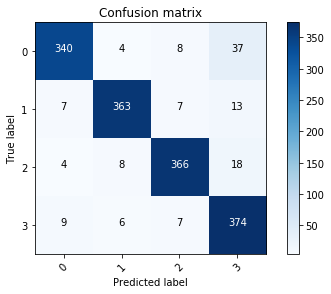

0.91894657804330271

In [30]:
evaluator = full_text_classifier.evaluate(df_test)
print(evaluator.get_metrics("ALL"))
evaluator.plot_confusion_matrix()
evaluator.get_metrics("macro_f1")

#### Save

In [31]:
full_model_file = os.path.join(working_dir, 'sk_model_full.zip')    
full_text_classifier.save(full_model_file)
full_model_file

BaseTextModel::save ==> start
TatkPipeline::save ==> start
copy dictionary file from  C:\Users\tatk\tatk\resources\dictionaries\newsgroup/dictionaries/20news.lex.txt
copy dictionary file from  C:\Users\tatk\tatk\resources\dictionaries\newsgroup/dictionaries/20news.lex.txt
Time taken: 0.13 mins
TatkPipeline::save ==> end
Time taken: 0.39 mins
BaseTextModel::save ==> end


'C:\\Users\\tatk\\tatk\\resources\\data\\outputs\\sk_model_full.zip'

#### deployment

In [32]:
# Download the deployment config file from Blob storage `url` and save it locally under `file_name`:
deployment_config_file_url = 'https://aztatksa.blob.core.windows.net/dailyrelease/tatk_deploy_config.yaml'
deployment_config_file_path=os.path.join(resources_dir, 'tatk_deploy_config.yaml')
if not os.path.exists(deployment_config_file_path):
    import urllib.request
    print('downloading {}'.format(deployment_config_file_path))
    urllib.request.urlretrieve(deployment_config_file_url, deployment_config_file_path)
deployment_config_file_path

'C:\\Users\\tatk\\tatk\\resources\\tatk_deploy_config.yaml'

In [33]:
working_directory =r'<please provide a working directory on your machine here>'
web_service_name = 'multitext2-classifier'

web_service_full = full_text_classifier.deploy(web_service_name= web_service_name, 
                       config_file_path=deployment_config_file_path,
                       working_directory= working_directory)  

The deployment has started.
Checking CLI azure machine learning installation setting
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az account set --subscription Azure Internal - Carl
running az group list
Checking CLI azure machine learning model management setting
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml account modelmanagement list
Will use model management account: "tutorial4vienna-model-mgr".
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml account modelmanagement set -n tutorial4vienna-model-mgr -g ner-rg
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml env list
Checking CLI azure machine learning environment setting
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az provider list
Checking provider registration...
All required providers are registered.
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml env show -n env4textclassifier -g env4textclassifierrg
ru

Additional usage information: 'az ml service usage realtime -i multitext2-classifier.env4textclassifier-7d271640.eastus2'
Deployment finished successfully!
changing the working directory back to : C:\Users\tatk\Documents\AzureML\TATK-Tutorial
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service list realtime
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service list realtime
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service show realtime --name multitext2-classifier
[
  {
    "Id": "multitext2-classifier.env4textclassifier-7d271640.eastus2",
    "Image_URL": "mlcrpacr91e76789f01e.azurecr.io/multitext2-classifier:1",
    "Manifest_Name": "multitext2-classifier",
    "Manifest_Version": 1,
    "Models": "pipeline.zip [Ver. 3]",
    "Name": "multitext2-classifier",
    "Service_Type": "Realtime",
    "State": "Succeeded",
    "UpdatedAt": "2018-05-04T00:48:06.7088126+00:00"
  }
]
running C:\Users\tatk\AppData\loc

    https://analytics.applicationinsights.io/subscriptions/c54e1fd7-0eae-4e7a-bea9-fae9d22b6c5e/resourcegroups/env4textclassifierrg-azureml-561a2/components/mlcrpai745052274204#/discover/home?apptype=Other%20(preview)
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service show realtime --name multitext2-classifier
[
  {
    "Id": "multitext2-classifier.env4textclassifier-7d271640.eastus2",
    "Image_URL": "mlcrpacr91e76789f01e.azurecr.io/multitext2-classifier:1",
    "Manifest_Name": "multitext2-classifier",
    "Manifest_Version": 1,
    "Models": "pipeline.zip [Ver. 3]",
    "Name": "multitext2-classifier",
    "Service_Type": "Realtime",
    "State": "Succeeded",
    "UpdatedAt": "2018-05-04T00:48:06.7088126+00:00"
  }
]
running C:\Users\tatk\AppData\local\AmlWorkbench\Python\Scripts\az ml service keys realtime --id multitext2-classifier.env4textclassifier-7d271640.eastus2
PrimaryKey: iempd5stlmbufNTScA5WnU9hQoJarH8y
SecondaryKey: BVLBjcnT9O3AI4APgaCZf7vqR3Us

In [34]:
print("Service URL: {}".format(web_service_full._service_url))
print("Service Key: {}".format(web_service_full._api_key))

Service URL: http://104.209.174.31/api/v1/service/multitext2-classifier/score
Service Key: iempd5stlmbufNTScA5WnU9hQoJarH8y


use the service URL and Key from the above cell to call the Web Service

In [35]:
from tatk.operationalization.csi.csi_web_service import CsiWebService
url = "<please type the service URL here>"
key = "<please type the service Key here>"
web_service = CsiWebService(url, key)

In [36]:
import json
dict1 ={}
dict1["recordId"] = "r1" 
dict1["data"]= {}
dict1["data"]["text1"] = "From: warsaw@athena.mit.edu (Daniel Maung)\nSubject: CDs for $6\nOrganization: "
dict1["data"]["text2"] = "alfredo.mit.edu\n\nI have the following CDs for sale for $6 each plus postage"
dict1["data"]["random_col"] = 0.14830781248804814
dict1["data"]["bool_col"] = False


dict2 ={}
dict2["recordId"] = "r2"
dict2["data"] ={}
dict2["data"]["text1"] = "information regarding the implementaion of total\n: quality management, quality control, quality assurance in the delivery of\n: health care service.  I would appreciate any information.  If there is enough\n:interest, I will post the responses.\n\n\nThis is in fact a hot topic in medicine these days, and much of the\nmedical literature is devoted to this.  The most heavily funded studies\nthese days are for outcome research, and physicians (and others!) are\nconstantly questionning whether what we do it truly effective in any given\nsituation"
dict2["data"]["text2"] = "information regarding the implementaion of total\n: quality management, quality control, quality assurance in the delivery of\n: health care service.  I would appreciate any information.  If there is enough\n:interest, I will post the responses.\n\n\nThis is in fact a hot topic in medicine these days, and much of the\nmedical literature is devoted to this.  The most heavily funded studies\nthese days are for outcome research, and physicians (and others!) are\nconstantly questionning whether what we do it truly effective in any given\nsituation"
dict2["data"]["random_col"] = 0.38243678264962366
dict2["data"]["bool_col"] = True


dict_list =[dict1, dict2]
data ={}
data["values"] = dict_list
input_data_json_str = json.dumps(data)
print (input_data_json_str)


prediction = web_service.score(input_data_json_str)
prediction

{"values": [{"recordId": "r1", "data": {"bool_col": false, "random_col": 0.14830781248804814, "text1": "From: warsaw@athena.mit.edu (Daniel Maung)\nSubject: CDs for $6\nOrganization: ", "text2": "alfredo.mit.edu\n\nI have the following CDs for sale for $6 each plus postage"}}, {"recordId": "r2", "data": {"bool_col": true, "random_col": 0.38243678264962366, "text1": "information regarding the implementaion of total\n: quality management, quality control, quality assurance in the delivery of\n: health care service.  I would appreciate any information.  If there is enough\n:interest, I will post the responses.\n\n\nThis is in fact a hot topic in medicine these days, and much of the\nmedical literature is devoted to this.  The most heavily funded studies\nthese days are for outcome research, and physicians (and others!) are\nconstantly questionning whether what we do it truly effective in any given\nsituation", "text2": "information regarding the implementaion of total\n: quality managemen

'{"values": [{"data": {"bool_col": false, "class": 1, "random_col": 0.14830781248804814, "text2": "alfredo.mit.edu\\n\\nI have the following CDs for sale for $6 each plus postage", "text1": "From: warsaw@athena.mit.edu (Daniel Maung)\\nSubject: CDs for $6\\nOrganization: "}, "recordId": "r1"}, {"data": {"bool_col": true, "class": 3, "random_col": 0.38243678264962366, "text2": "information regarding the implementaion of total\\n: quality management, quality control, quality assurance in the delivery of\\n: health care service.  I would appreciate any information.  If there is enough\\n:interest, I will post the responses.\\n\\n\\nThis is in fact a hot topic in medicine these days, and much of the\\nmedical literature is devoted to this.  The most heavily funded studies\\nthese days are for outcome research, and physicians (and others!) are\\nconstantly questionning whether what we do it truly effective in any given\\nsituation", "text1": "information regarding the implementaion of total

## Next steps

Learn more about Azure Machine Learning Package for Text Analytics in these articles:

+ Read the [package overview and learn how to install it](https://aka.ms/aml-packages/text).

+ Explore the [reference documentation](https://aka.ms/aml-packages/text) for this package.

+ Learn about [other Python packages for Azure Machine Learning](reference-python-package-overview.md).

© 2018 Microsoft. All rights reserved.